ML2 Practical Assignment 3

In [ ]:
pip install numpy matplotlib tensorflow keras h5py seaborn librosa scikit-learn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
(128, 517, 172)


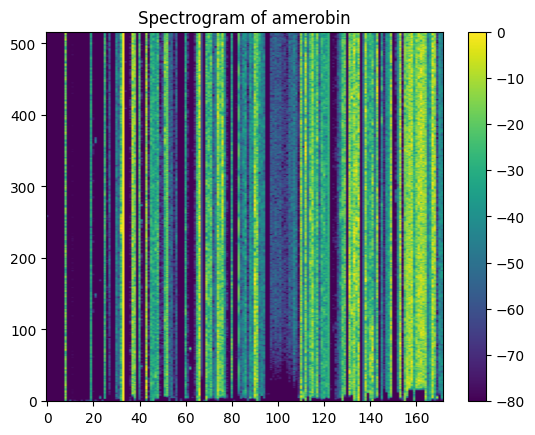

In [ ]:
# Importing required libraries :
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Loading the HDF5 file from Google Drive :
f = h5py.File('/content/drive/MyDrive/bird_spectrograms.hdf5', 'r')

# Viewing species keys :
print(list(f.keys()))

# Viewing the shape of one species' dataset : American Robin:
data = f['amerob'][:]
print(data.shape)
plt.imshow(data[0], aspect='auto', origin='lower')
plt.title("Spectrogram of amerobin")
plt.colorbar()
plt.show()


In [12]:
#Viewing all the Species and their shapes:

f = '/content/drive/MyDrive/bird_spectrograms.hdf5'

with h5py.File(f, 'r') as f:
    print("Species keys :")
    for key in f.keys():
        print(f"  {key} -> shape: {f[key].shape}, dtype: {f[key].dtype}")


    if "spectrograms" in f and "labels" in f:
        print("\nSpectrogram sample shape:", f["spectrograms"][0].shape)
        print("First few labels:", f["labels"][:5])


Species keys :
  amecro -> shape: (128, 517, 66), dtype: float64
  amerob -> shape: (128, 517, 172), dtype: float64
  bewwre -> shape: (128, 517, 144), dtype: float64
  bkcchi -> shape: (128, 517, 45), dtype: float64
  daejun -> shape: (128, 517, 125), dtype: float64
  houfin -> shape: (128, 517, 84), dtype: float64
  houspa -> shape: (128, 517, 630), dtype: float64
  norfli -> shape: (128, 517, 37), dtype: float64
  rewbla -> shape: (128, 517, 187), dtype: float64
  sonspa -> shape: (128, 517, 263), dtype: float64
  spotow -> shape: (128, 517, 137), dtype: float64
  whcspa -> shape: (128, 517, 91), dtype: float64


In [13]:
# Viewing the samples and familiarizing with the shape :
filename = '/content/drive/MyDrive/bird_spectrograms.hdf5'
X = []
y = []
species_list = []

with h5py.File(filename, 'r') as f:
    for i, bird in enumerate(f.keys()):
        data = np.array(f[bird])  # Original shape (128, 517, No. of Samples)
        data = np.transpose(data, (2, 0, 1))  # New shape (No. of Samples, 128, 517)
        X.append(data)
        y.append(np.full(data.shape[0], i))
        species_list.append(bird)

X = np.concatenate(X)
y = np.concatenate(y)
species_list = np.array(species_list)

print("Total samples:", X.shape[0])
print("Shape of each spectrogram:", X.shape[1:])
print("Labels:", np.unique(y))



Total samples: 1981
Shape of each spectrogram: (128, 517)
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


1) BINARY MODEL - 1 :

 1. Data Loading & Preprocessing

In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load HDF5 dataset
f = h5py.File('/content/drive/MyDrive/bird_spectrograms.hdf5', 'r')

# Load rewbla and whcspa: shape (128, 517, N_samples)
rewbla_data = f['rewbla'][:]
whcspa_data = f['whcspa'][:]

# Transpose to (samples, 128, 517)
rewbla_data = np.transpose(rewbla_data, (2, 0, 1))
whcspa_data = np.transpose(whcspa_data, (2, 0, 1))

print(f"rewbla shape: {rewbla_data.shape}")
print(f"whcspa shape: {whcspa_data.shape}")

# Labels: rewbla = 0, whcspa = 1
rewbla_labels = np.zeros(len(rewbla_data))
whcspa_labels = np.ones(len(whcspa_data))

# Combine data
X = np.concatenate((rewbla_data, whcspa_data), axis=0)
y = np.concatenate((rewbla_labels, whcspa_labels), axis=0)

# Normalize per sample (min-max scaling)
X = (X - X.min(axis=(1,2), keepdims=True)) / (X.max(axis=(1,2), keepdims=True) - X.min(axis=(1,2), keepdims=True))

# Add channel dimension: (samples, 128, 517, 1)
X = X[..., np.newaxis]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


rewbla shape: (187, 128, 517)
whcspa shape: (91, 128, 517)
Train shape: (222, 128, 517, 1), Test shape: (56, 128, 517, 1)


2 Build CNN Model

In [ ]:
from tensorflow.keras import layers, models

def create_binary_cnn(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create model
input_shape = X_train.shape[1:]
binary_model = create_binary_cnn(input_shape)

# Summary
binary_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 517, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,993 (394.50 KB)

 Trainable params: 100,993 (394.50 KB)

 Non-trainable params: 0 (0.00 B)

3. Training the Model


In [ ]:
history = binary_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4894 - loss: 0.6869 - val_accuracy: 0.6000 - val_loss: 0.6730
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7238 - loss: 0.6197 - val_accuracy: 0.6000 - val_loss: 0.6941
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6931 - loss: 0.6199 - val_accuracy: 0.6000 - val_loss: 0.6713
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7083 - loss: 0.6304 - val_accuracy: 0.6000 - val_loss: 0.6736
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6563 - loss: 0.6503 - val_accuracy: 0.6000 - val_loss: 0.6847
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7229 - loss: 0.6148 - val_accuracy: 0.6000 - val_loss: 0.6978
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.6797 - loss: 0.6333 - val_accuracy: 0.6000 - val_loss: 0.6853
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7070 - loss: 0.6105 - val_accuracy: 0.6000 - val_loss: 0.6814
Epoch 9/

4. Evaluation & Metrics

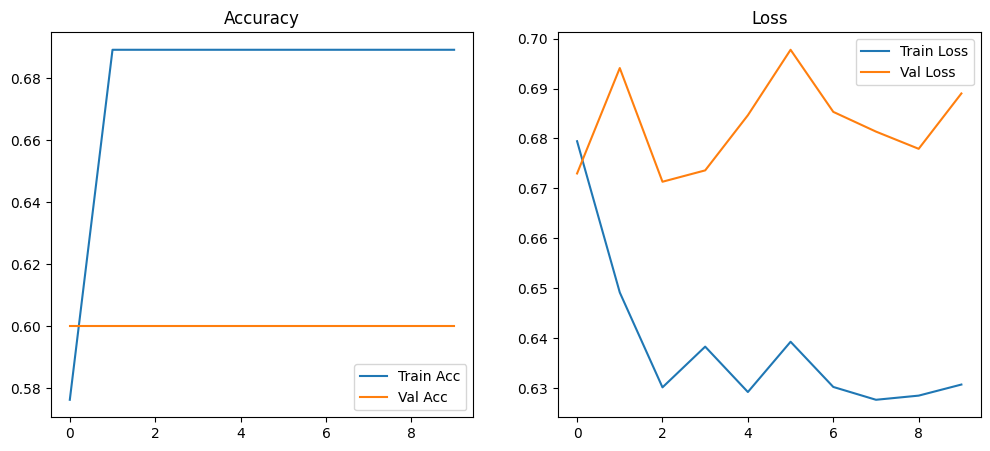

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 804ms/step - accuracy: 0.6815 - loss: 0.6345
Test Accuracy: 0.68


In [ ]:
# Plot Accuracy & Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_acc = binary_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


5. Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


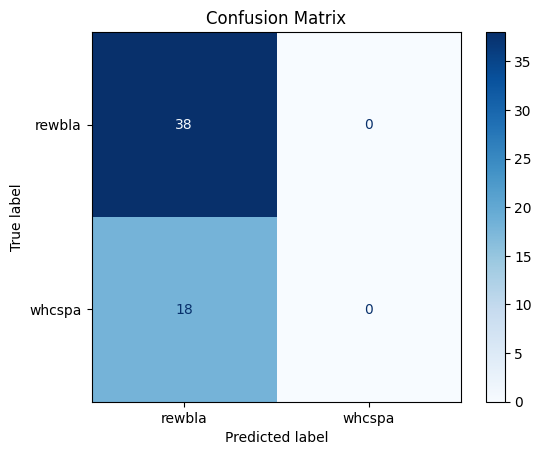

In [ ]:
# Predict labels
y_pred = (binary_model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rewbla', 'whcspa'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


Binary Model 2:  Add Dropout

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 517, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,993 (394.50 KB)

 Trainable params: 100,993 (394.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.6308 - loss: 0.6723 - val_accuracy: 0.6000 - val_loss: 0.6712
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.6733 - loss: 0.6562 - val_accuracy: 0.6000 - val_loss: 0.6712
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.6946 - loss: 0.6383 - val_accuracy: 0.6000 - val_loss: 0.6719
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.6794 - loss: 0.6436 - val_accuracy: 0.6000 - val_loss: 0.6717
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.6791 - loss: 0.6493 - val_accuracy: 0.6000 - val_loss: 0.6715
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.7197 - loss: 0.6142 - val_accuracy: 0.6000 - val_loss: 0.6721
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.6838 - loss: 0.6412 - val_accuracy: 0.6000 - val_loss: 0.6724
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.6809 - loss: 0.6367 - val_accuracy: 0.6000 - val_loss: 0.6717
Epoch 9/

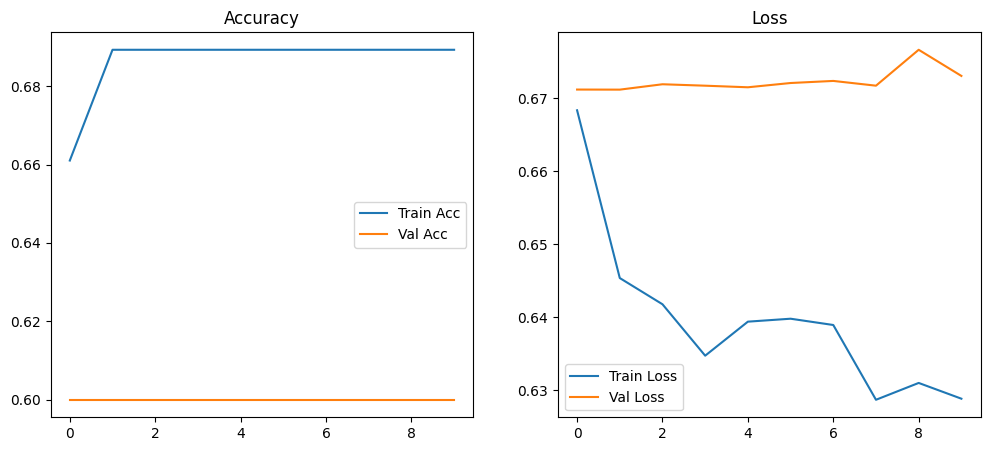

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 921ms/step - accuracy: 0.6815 - loss: 0.6362
Test Accuracy: 0.68
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 932ms/step


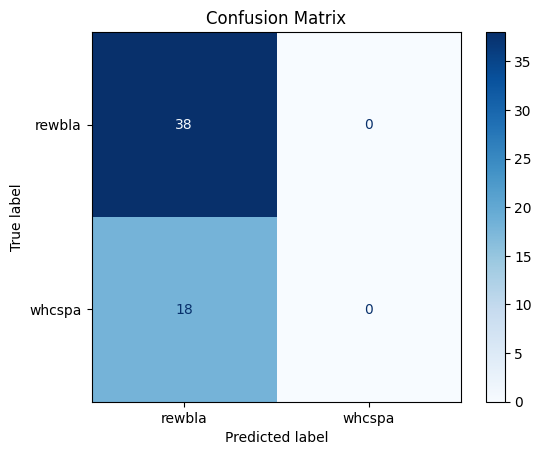

In [ ]:
from tensorflow.keras import layers, models

def create_binary_cnn(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),  # Dropout
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create model
input_shape = X_train.shape[1:]
binary_model = create_binary_cnn(input_shape)

binary_model.summary()

history = binary_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


# Plot Accuracy & Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_acc = binary_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


# Predict labels
y_pred = (binary_model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rewbla', 'whcspa'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
print(f"rewbla samples: {rewbla_data.shape[0]}")
print(f"whcspa samples: {whcspa_data.shape[0]}")


rewbla samples: 187
whcspa samples: 91


In [ ]:
  history = binary_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.6970 - loss: 0.6190 - val_accuracy: 0.6000 - val_loss: 0.6820
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.7477 - loss: 0.5837 - val_accuracy: 0.6000 - val_loss: 0.6800
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6582 - loss: 0.6464 - val_accuracy: 0.6000 - val_loss: 0.6731
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7019 - loss: 0.6232 - val_accuracy: 0.6000 - val_loss: 0.6824
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6870 - loss: 0.6233 - val_accuracy: 0.6000 - val_loss: 0.6925
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6775 - loss: 0.6348 - val_accuracy: 0.6000 - val_loss: 0.6802
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6542 - loss: 0.6466 - val_accuracy: 0.6000 - val_loss: 0.6835
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6774 - loss: 0.6324 - val_accuracy: 0.6000 - val_loss: 0.6997
Epoch 9/

Binary Model 3

In [ ]:

# Binary CNN Model with Dropout, Class Weighting, LR Scheduling, Threshold Tuning

import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Model architecture
binary_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Model training
history = binary_model.fit(
    X_train, y_train,
    epochs=20, batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluation on test set
y_pred_prob = binary_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Confusion Matrix (Threshold=0.5):\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report (Threshold=0.5):\n", classification_report(y_test, y_pred))

# Threshold tuning
threshold = 0.4
y_pred_tuned = (y_pred_prob > threshold).astype(int)
print(f"\nConfusion Matrix (Threshold={threshold}):\n", confusion_matrix(y_test, y_pred_tuned))
print(f"\nClassification Report (Threshold={threshold}):\n", classification_report(y_test, y_pred_tuned))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class Weights: {0: np.float64(0.7449664429530202), 1: np.float64(1.5205479452054795)}
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.4275 - loss: 0.6927 - val_accuracy: 0.6000 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.5778 - loss: 0.6962 - val_accuracy: 0.6000 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.6339 - loss: 0.6811 - val_accuracy: 0.6000 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5171 - loss: 0.6911 - val_accuracy: 0.6000 - val_loss: 0.6906 - learning_rate: 5.0000e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 938ms/step
Confusion Matrix (Threshold=0.5):
 [[38  0]
 [18  0]]

Classification Report (Threshold=0.5):
               precision    recall  f1-score   support

         0.0       0.68      1.00      0.81        38
         1.0       0.00      0.00      0.00        18

    accuracy        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

PART 2 : MULTI-CLASS CLASSIFICATION :

 Multi-Class Model 1 :
1. Load Data

In [ ]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load data
file_path = '/content/drive/MyDrive/bird_spectrograms.hdf5'
species_list = ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin',
                'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']

X_data = []
y_data = []

with h5py.File(file_path, 'r') as f:
    for idx, species in enumerate(species_list):
        data = f[species][:]
        X_data.append(data)
        y_data.append(np.full(data.shape[2], idx))  # Labels for species

X_data = np.concatenate(X_data, axis=2)
y_data = np.concatenate(y_data)




# Normalizing each spectrogram sample to [0, 1]
X_data = np.transpose(X_data, (2, 0, 1))

# Per-sample min-max normalization
X_data_norm = []
for sample in X_data:
    sample_min = sample.min()
    sample_max = sample.max()
    if sample_max - sample_min != 0:
        norm_sample = (sample - sample_min) / (sample_max - sample_min)
    else:
        norm_sample = np.zeros_like(sample)
    X_data_norm.append(norm_sample)

X_data = np.array(X_data_norm)
 # Add channel dimension
X_data = np.expand_dims(X_data, axis=-1)

print("Normalized X_data min:", X_data.min(), "max:", X_data.max())

# One-hot encode labels
y_data = to_categorical(y_data, num_classes=len(species_list))

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data.argmax(axis=1), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp.argmax(axis=1), random_state=42)

X_train.shape, X_val.shape, X_test.shape


Normalized X_data min: 0.0 max: 1.0


((1386, 128, 517, 1), (297, 128, 517, 1), (298, 128, 517, 1))

2. Build CNN Model

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(len(species_list), activation='softmax')
])

model.summary()

3. Compile & Train

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, reduce_lr])


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.1046 - loss: 780322.0625 - val_accuracy: 0.0875 - val_loss: 8649.9141 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - accuracy: 0.3114 - loss: 5.2191 - val_accuracy: 0.0438 - val_loss: 8800.6465 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.3240 - loss: 2.4519 - val_accuracy: 0.0438 - val_loss: 8948.1533 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3303 - loss: 2.4325
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
44/44 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.3300 - loss: 2.4324 - val_accuracy: 0.0438 - val_loss: 8949.7510 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - accuracy: 0.3280 - loss: 2.4164 - val_accuracy: 0.0438 - val_loss: 8949.7334 - learning_rate: 5.0000e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.2883 - l

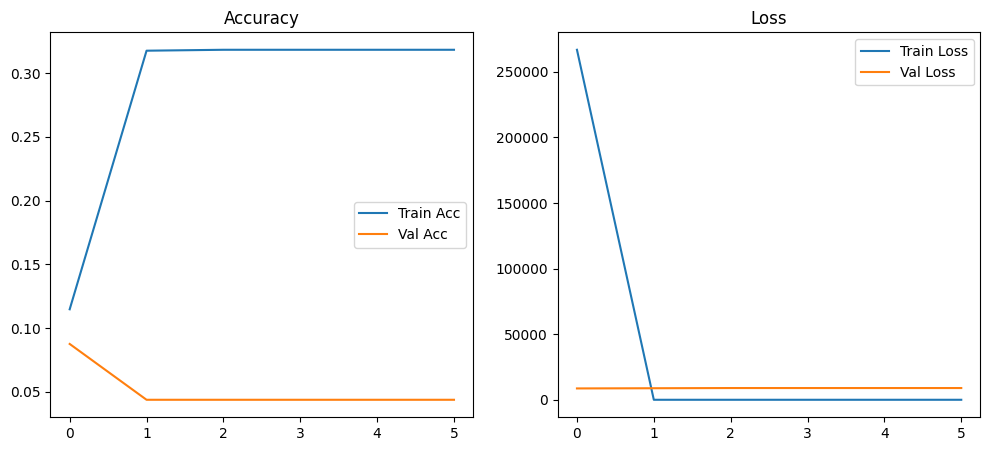

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


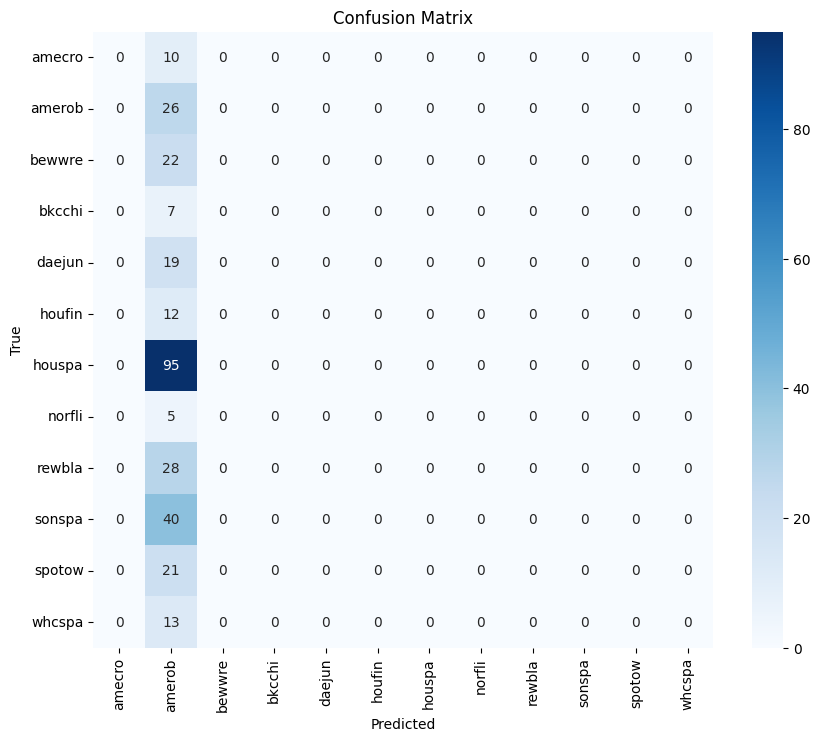

              precision    recall  f1-score   support

      amecro       0.00      0.00      0.00        10
      amerob       0.09      1.00      0.16        26
      bewwre       0.00      0.00      0.00        22
      bkcchi       0.00      0.00      0.00         7
      daejun       0.00      0.00      0.00        19
      houfin       0.00      0.00      0.00        12
      houspa       0.00      0.00      0.00        95
      norfli       0.00      0.00      0.00         5
      rewbla       0.00      0.00      0.00        28
      sonspa       0.00      0.00      0.00        40
      spotow       0.00      0.00      0.00        21
      whcspa       0.00      0.00      0.00        13

    accuracy                           0.09       298
   macro avg       0.01      0.08      0.01       298
weighted avg       0.01      0.09      0.01       298



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot accuracy and Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Predict the test set
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_test.argmax(axis=1)

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='d',
            xticklabels=species_list, yticklabels=species_list, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true_labels, y_pred_labels, target_names=species_list))



Multi - Class Model 2

In [ ]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(y_data.argmax(axis=1), num_classes=12)

X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data.argmax(axis=1), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp.argmax(axis=1), random_state=42)

 # Building Model :
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

model.summary()

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, reduce_lr])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 517, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 517, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 258, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 129, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,872,460 (64.36 MB)

 Trainable params: 16,872,012 (64.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 378s 9s/step - accuracy: 0.1470 - loss: 24.9216 - val_accuracy: 0.1313 - val_loss: 60.2378 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 381s 9s/step - accuracy: 0.2980 - loss: 2.5208 - val_accuracy: 0.1313 - val_loss: 72.5728 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 365s 8s/step - accuracy: 0.3053 - loss: 2.4508 - val_accuracy: 0.3165 - val_loss: 72.0698 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 371s 8s/step - accuracy: 0.3250 - loss: 2.4286 - val_accuracy: 0.3165 - val_loss: 99.5892 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.3157 - loss: 2.4262 - val_accuracy: 0.3165 - val_loss: 94.1496 - learning_rate: 5.0000e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 370s 8s/step - accuracy: 0.3212 - loss: 2.4014 - val_accuracy: 0.3165 - val_loss: 81.9649 - learning_rate: 5.0000e-04


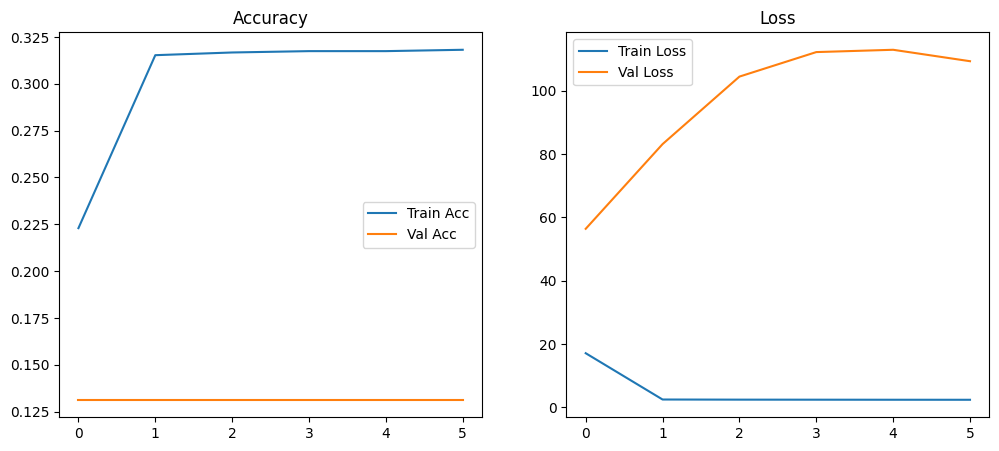

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


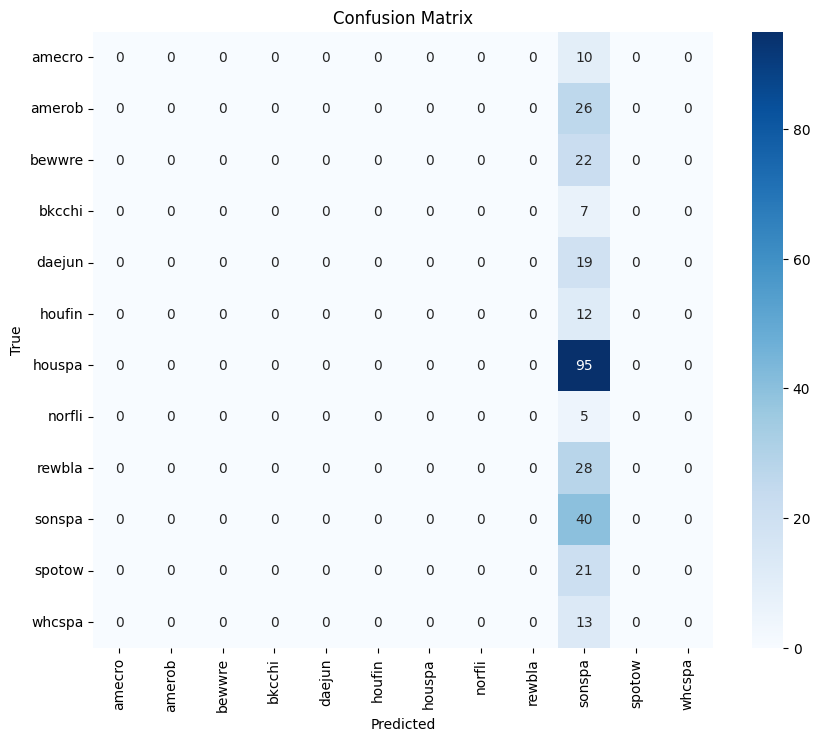

              precision    recall  f1-score   support

      amecro       0.00      0.00      0.00        10
      amerob       0.00      0.00      0.00        26
      bewwre       0.00      0.00      0.00        22
      bkcchi       0.00      0.00      0.00         7
      daejun       0.00      0.00      0.00        19
      houfin       0.00      0.00      0.00        12
      houspa       0.00      0.00      0.00        95
      norfli       0.00      0.00      0.00         5
      rewbla       0.00      0.00      0.00        28
      sonspa       0.13      1.00      0.24        40
      spotow       0.00      0.00      0.00        21
      whcspa       0.00      0.00      0.00        13

    accuracy                           0.13       298
   macro avg       0.01      0.08      0.02       298
weighted avg       0.02      0.13      0.03       298



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Multi-Model 2 plot
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot accuracy and Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Predict test set
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_test.argmax(axis=1)

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='d',
            xticklabels=species_list, yticklabels=species_list, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true_labels, y_pred_labels, target_names=species_list))



Multi -Model 3

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

# Improved Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict,
                    callbacks=[early_stop, reduce_lr])


Class Weights: {0: np.float64(2.510869565217391), 1: np.float64(0.9625), 2: np.float64(1.1435643564356435), 3: np.float64(3.725806451612903), 4: np.float64(1.3275862068965518), 5: np.float64(1.9576271186440677), 6: np.float64(0.2619047619047619), 7: np.float64(4.4423076923076925), 8: np.float64(0.8816793893129771), 9: np.float64(0.6277173913043478), 10: np.float64(1.203125), 11: np.float64(1.8046875)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 414s 9s/step - accuracy: 0.0938 - loss: 2.8802 - val_accuracy: 0.0943 - val_loss: 2.5715 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 434s 9s/step - accuracy: 0.0809 - loss: 2.7190 - val_accuracy: 0.0606 - val_loss: 2.7023 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 404s 9s/step - accuracy: 0.1029 - loss: 2.5784 - val_accuracy: 0.0673 - val_loss: 2.4852 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 441s 9s/step - accuracy: 0.1181 - loss: 2.4732 - val_accuracy: 0.0673 - val_loss: 2.5235 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 444s 9s/step - accuracy: 0.1091 - loss: 2.4562 - val_accuracy: 0.0707 - val_loss: 3.1381 - learning_rate: 0.0010
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 442s 9s/step - accuracy: 0.1468 - loss: 2.3875 - val_accuracy: 0.0673 - val_loss: 3.6571 - learning_rate: 0.0010
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 480s 10s/step - accuracy: 0.1277 - loss: 2.5582 - val_ac

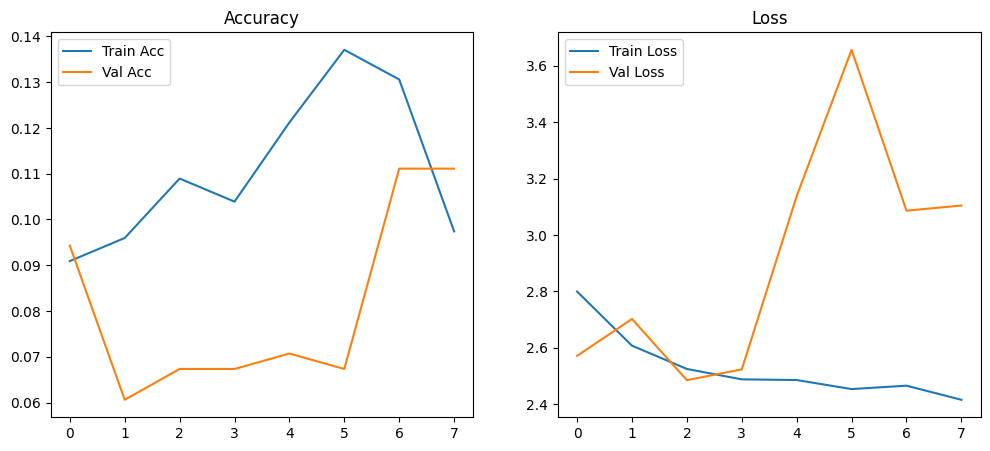

10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


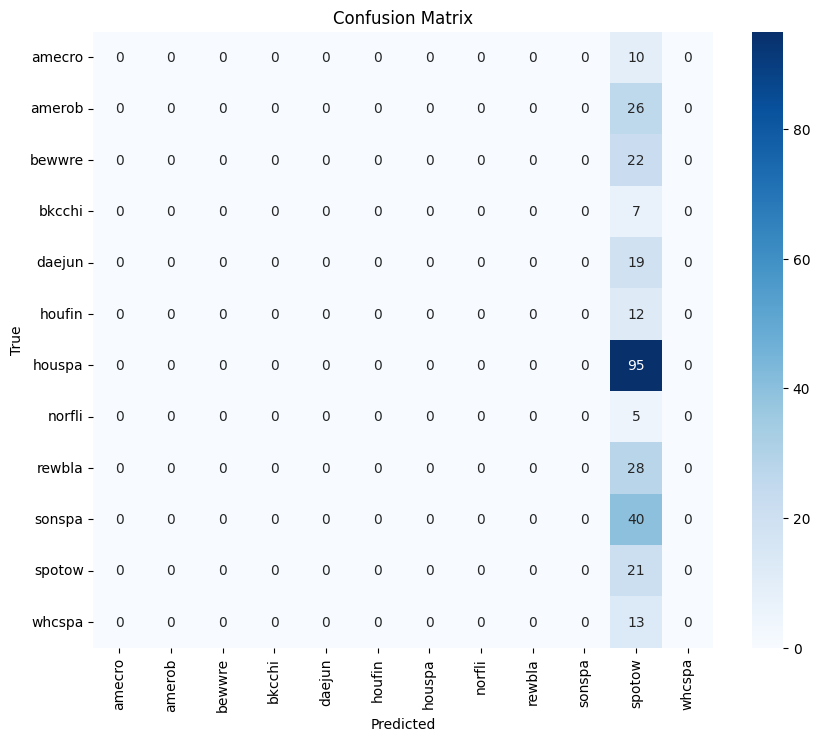

              precision    recall  f1-score   support

      amecro       0.00      0.00      0.00        10
      amerob       0.00      0.00      0.00        26
      bewwre       0.00      0.00      0.00        22
      bkcchi       0.00      0.00      0.00         7
      daejun       0.00      0.00      0.00        19
      houfin       0.00      0.00      0.00        12
      houspa       0.00      0.00      0.00        95
      norfli       0.00      0.00      0.00         5
      rewbla       0.00      0.00      0.00        28
      sonspa       0.00      0.00      0.00        40
      spotow       0.07      1.00      0.13        21
      whcspa       0.00      0.00      0.00        13

    accuracy                           0.07       298
   macro avg       0.01      0.08      0.01       298
weighted avg       0.00      0.07      0.01       298



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
 # Best plot so far since Accuracy increased and val loss increased :


import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot accuracy & loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Predict on test set
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_test.argmax(axis=1)

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='d',
            xticklabels=species_list, yticklabels=species_list, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true_labels, y_pred_labels, target_names=species_list))



Multi Model 4 : Focal Loss :46 mins

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
44/44 - 376s - 9s/step - accuracy: 0.2633 - loss: 2.7236 - val_accuracy: 0.0236 - val_loss: 2.4537 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 - 380s - 9s/step - accuracy: 0.3052 - loss: 2.6426 - val_accuracy: 0.0471 - val_loss: 2.9700 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 - 369s - 8s/step - accuracy: 0.2944 - loss: 2.3989 - val_accuracy: 0.0236 - val_loss: 2.5229 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
44/44 - 381s - 9s/step - accuracy: 0.2013 - loss: 1.1052 - val_accuracy: 0.0943 - val_loss: 2.6386 - learning_rate: 1.0000e-04
Epoch 5/30
44/44 - 383s - 9s/step - accuracy: 0.2828 - loss: 0.5677 - val_accuracy: 0.0943 - val_loss: 3.1031 - learning_rate: 5.0000e-05
Epoch 6/30
44/44 - 432s - 10s/step - accuracy: 0.3038 - loss: 0.5024 - val_accuracy: 0.0943 - val_loss: 3.2656 - learning_rate: 5.0000e-05
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
44/44 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


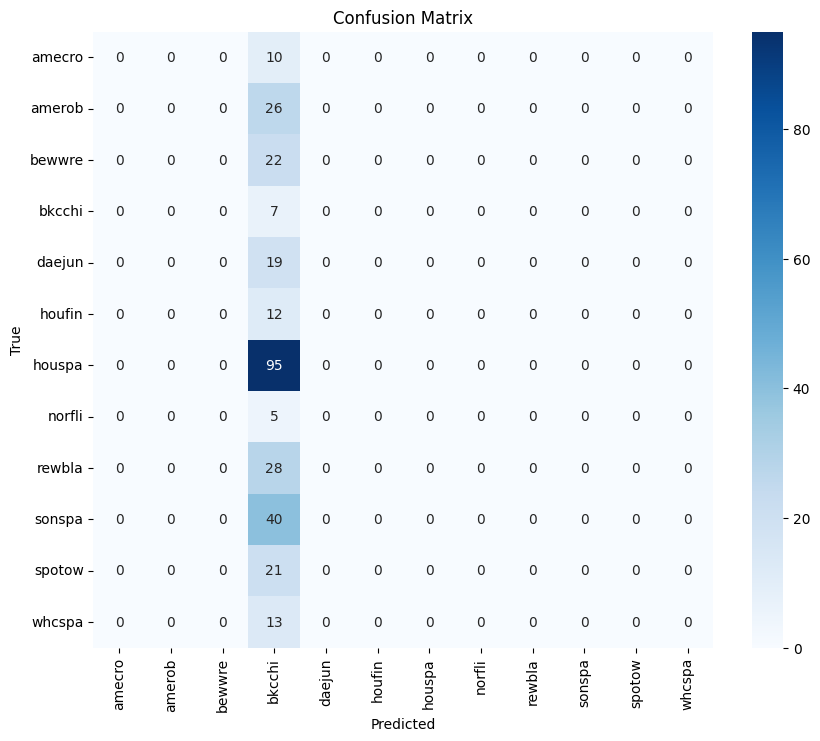

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Data Loading
h5_file = '/content/drive/MyDrive/bird_spectrograms.hdf5'
f = h5py.File(h5_file, 'r')

species_list = list(f.keys())

X_list = []
y_list = []

for idx, species in enumerate(species_list):
    data = f[species][:]
    data = np.transpose(data, (2, 0, 1))
    X_list.append(data)
    y_list.append(np.full(data.shape[0], idx))

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

# Normalize per sample (min-max)
X = (X - X.min(axis=(1, 2), keepdims=True)) / (X.max(axis=(1, 2), keepdims=True) - X.min(axis=(1, 2), keepdims=True) + 1e-8)

# Add channel dimension
X = X[..., np.newaxis]

# Train-Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# One-hot encode labels
num_classes = len(species_list)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

#  Focal Loss
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

#  CNN Model
model = Sequential([
    InputLayer(input_shape=(128, 517, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

#  Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

#  Train Model
history = model.fit(X_train, y_train_cat,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val, y_val_cat),
                    callbacks=[reduce_lr, early_stop],
                    verbose=2)

#  Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

#  Classification Report
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=species_list))

#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=species_list, yticklabels=species_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
